In [17]:
################################
#### IMPORTS AND INICIALIZATIONS
################################

import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt

data = 'RAVEN/TrialRightWrong/Trial'

# All the files we need
files = ['/DEI_trial_by_trial_Right.xlsx', 
         '/DEI_trial_by_trial_Wrong.xlsx', 
         '/esec_trial_by_trial_Right.xlsx',
         '/esec_trial_by_trial_Wrong.xlsx']
genreFile = 'RAVEN/Informação_género.txt'

In [42]:
####################################
#### EXTRACT DATA AND PRE-PROCESSING
####################################

# Initialize a dict for aggregate the fatigue values for each person and if answer right/wrong a question
values = { 'TRAINING': {}, 'TESTING': {} }
for file in files:
    
    # For each file
    f = pd.ExcelFile(data+file)

    # For each Train
    for sheet in f.sheet_names:
        
        df = pd.read_excel(f,  sheet_name=sheet)
        # Get the fatigue value for each person
        # In the 'unnamed:22' column is where person id is
        # Notice that if a person isn't in the 'right files', so he is in the 'wrong files' 
        category = 'TRAINING' if 'TRAINING' in sheet else 'TESTING' if 'TESTING' in sheet else None  
        if category and df.shape[0] > 0:
            dataValues = values[category]
            for index, row in df[['Unnamed: 22', 'FATIGUE DISPLAY']].iterrows():
                # cell = [genre, course, fatigue_value, correct(1)/incorret(0)]
                id, fatigue = row 
                cell = []
                cell += [int("DEI" in id), fatigue] #[int(row[0]=="DEI"),sheet, row[1]]
                cell += [1 if (file=='/DEI_trial_by_trial_Right.xlsx' or file=='/esec_trial_by_trial_Right.xlsx') else 0]
                if (id not in dataValues):
                    dataValues[id] = [cell]
                else:
                    dataValues[id] += [cell] 
                    
#Extract the genre from genreFile
with open(genreFile, "r") as f:
    for l in f:
        l = l.strip()
        if l=="" or '--' in l:continue
        id, genre, *rest = l.split(' - ')
        if id[-2] == '_': id = id[:-1] + '0' + id[-1]
        for dataDict in [values['TRAINING'], values['TESTING']]: #get dicts train and test
            for i in range(len(dataDict[id])):
                dataDict[id][i][:0] = [int(genre=='Masculino')]  
        

# For each person ( PERSON : list([genre, course, fatigue_value, correct/incorrect ]))        
items = { 'TRAINING': [], 'TESTING': [] }
for dataType in ['TRAINING','TESTING']:
    for v in values[dataType].values():
        items[dataType] += v
items['TRAINING'] = np.matrix(items['TRAINING'])
items['TESTING'] = np.matrix(items['TESTING'])

data_trainX = normalize(items['TRAINING'][:,:-1], axis=0, norm='max')
data_trainY = items['TRAINING'][:,-1] 

data_testX = normalize(items['TESTING'][:,:-1], axis=0, norm='max')
data_testY = items['TESTING'][:,-1] 

print(data_testX.shape)

(1546, 3)


In [37]:
################################
#### NORMALIZE AND AGGREGATE
################################

avg = []
course_genre = []
correct = []

group = dataX[:, 0]+dataX[:, 1]*2
cg, count = np.unique(group, return_counts=True)

for t,c in zip(cg,count):
    validClass = (group == t) #True if it belongs to group genre/course
    fadigue = validClass * data_trainX[:,2]

    correctAnswers = validClass.T * data_trainY
    percCorrectAnswers = correctAnswers.sum()/c
    correct.append(percCorrectAnswers*100)

    avg.append(fadigue.sum()/c)
    course_genre.append(t)

print('Course with Genre:',course_genre, ', Avg:', avg)


Course with Genre: [0.0, 1.0, 2.0, 3.0] , Avg: [0.09414546389387059, 0.07288800960260808, 0.06794700481924863, 0.08449106687010134]


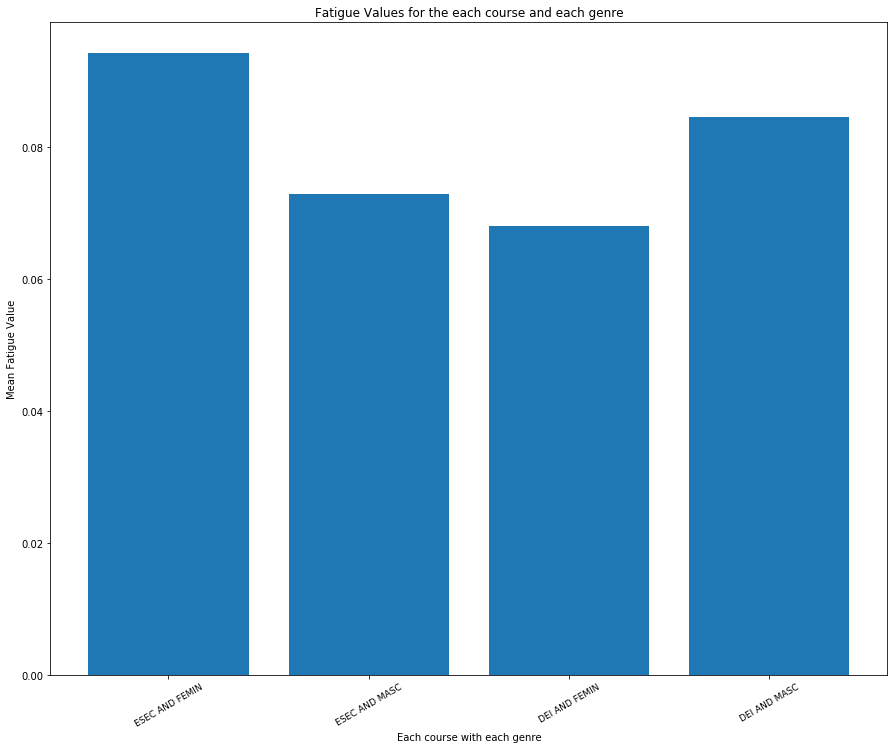

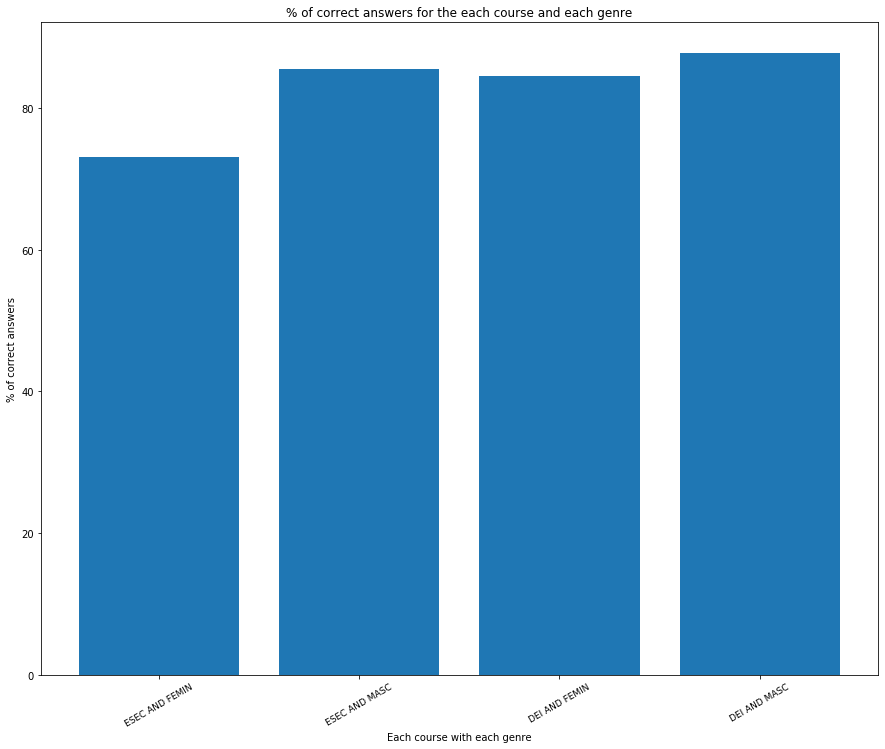

In [38]:
################################
#### PLOT INFO 
################################

# Fatigue Values for the each course and each genre
%matplotlib inline

x = ['ESEC AND FEMIN','ESEC AND MASC', 'DEI AND FEMIN', 'DEI AND MASC']
y = avg
plt.figure(figsize=(15,12))
plt.bar(x,y)
plt.title("Fatigue Values for the each course and each genre")
plt.xlabel('Each course with each genre')
plt.xticks(fontsize=9 , rotation=30)
plt.ylabel('Mean Fatigue Value')
plt.show()

# % of correct answers for the each course and each genre

plt.figure(figsize=(15,12))
y = correct
plt.bar(x,y)
plt.title("% of correct answers for the each course and each genre")
plt.xlabel('Each course with each genre')
plt.xticks(fontsize=9 , rotation=30)
plt.ylabel('% of correct answers')
plt.show()

